# Random Forest
Haytham Mohamed

INFS 890 - Spring 2020

In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.feature_selection import SelectKBest
import seaborn as sns
from sklearn import preprocessing, metrics, feature_selection
from datetime import datetime
from scipy import stats
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler , MinMaxScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import RFECV
from sklearn.decomposition import PCA

sns.set()
sns.set(color_codes=True)
#sns.set_color_codes()

pd.options.display.max_rows = 15
pd.options.display.float_format = '{:,.4f}'.format

Set this flag to True if you're using reduction feature using FCA, otherwise set it to False

In [67]:
# 1- read data file
# 1- read processed file
home_dir = '/Users/hmohamed/github/data-research-spring2020/sock-shop'
file_dir = home_dir + '/processed-data/'

#data_file = 'orders_flow_data.csv'   # raw data as is
#data_file = 'order_flow_cleanup_data.csv'
data_file = 'order_flow_normalized_data.csv'
#data_file = 'order_flow_standardized_data.csv'
#data_file = 'order_flow_factored_data.csv'


SCALE_TARGETS = True

test_split = 0.1

In [68]:
def read_df(file_dir, data_file, timeseries=True):
    df = pd.read_csv(file_dir + data_file)
    if timeseries:
        df = to_time_series(df)
    return df

def to_time_series(df, index_col_name='date'):
    df[index_col_name] = pd.to_datetime(df[index_col_name])
    df.set_index(index_col_name, inplace=True)
    df.sort_index(inplace=True)
    return df

def merge(df, series):
    return pd.merge_asof(df, series, left_index=True, right_index=True, tolerance=pd.Timedelta('1 second')).bfill()    


In [69]:
data = read_df(file_dir, data_file, True)
data = data.reset_index(drop=True)
data.head(5)

front-end_cpu_use  orders_cpu_use  orders-db_cpu_use  user_cpu_use  \
0             0.0700          0.0200             0.0100        0.0200   
1             0.0600          0.0300             0.0100        0.0200   
2             0.2100          0.0600             0.0200        0.0500   
3             0.2200          0.0600             0.0200        0.0600   
4             0.2100          0.0600             0.0100        0.0500   

   user-db_cpu_use  shipping_cpu_use  payment_cpu_use  carts_cpu_use  \
0           0.0200            0.0100           0.0100         0.1200   
1           0.0200            0.0100           0.0100         0.1400   
2           0.0300            0.0200           0.0100         0.2400   
3           0.0400            0.0200           0.0100         0.2100   
4           0.0400            0.0200           0.0100         0.1500   

   carts-db_cpu_use  front-end_pods  orders_pods  user_pods  shipping_pods  \
0            0.1600          1.0000       1.0000     1.0000         1.0000   
1            0.1700          1.0000       1.0000     1.0000         1.0000   
2            0.6600          1.0000       1.0000     1.0000         1.0000   
3            0.6600          1.0000       1.0000     1.0000         1.0000   
4            0.6600          1.0000       1.0000     1.0000         1.0000   

   payment_pods  carts_pods  nodes_cpu_use  orders_req  orders_ltcy  
0        1.0000      1.0000         1.1800      0.4000       0.4000  
1        1.0000      1.0000         1.1800      0.4400       0.3900  
2        1.0000      1.0000         1.8400      1.5800       0.4200  
3        1.0000      1.0000         1.8300      1.5800       0.4100  
4        1.0000      1.0000         1.7500      1.4900       0.3900

In [70]:
data.shape

(3175, 18)

In [71]:
targets = data['orders_ltcy']
inputs = data.drop(['orders_ltcy'], axis=1)

n_features = inputs.values.shape[1]
print("there are {} features".format(n_features))


there are 17 features


In [72]:
# scale targets for better convergence
if SCALE_TARGETS:
    y_scaler =  MinMaxScaler()
    targets = y_scaler.fit_transform(targets.values.reshape(-1,1))

In [73]:
x_train, x_test, y_train, y_test = \
    train_test_split(inputs, targets, test_size=test_split, shuffle=False, random_state=365)

if 1 == 0:
    # for better convergence and result scale target to values between 0 - 1
    y_train_max = y_train.max()
    y_test_max = y_test.max()

    y_train = y_train / y_train_max
    y_test = y_test / y_test_max


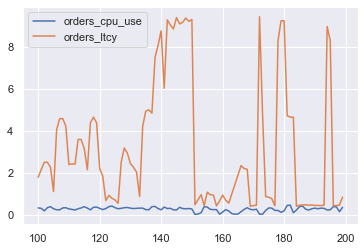

In [74]:
# plot cpu vs latency 
plt.plot(data['orders_cpu_use'][100:200], label='orders_cpu_use')
plt.plot(data['orders_ltcy'][100:200], label='orders_ltcy')
plt.legend()
plt.show()

#ax = sns.regplot(x=data['orders_cpu_use'], y=data['orders_ltcy'], color='g')


# Model

In [75]:
#lasso = LassoCV(fit_intercept=False,n_jobs=-1,random_state=0,selection='random',positive=False,cv=10)
#sfm1 = SelectFromModel(lasso, threshold='0.01*mean')

rfr = RandomForestRegressor(n_jobs=-1, max_depth=10, n_estimators=20)
sfm = SelectFromModel(rfr, threshold='0.01*mean')

#sfm = SelectKBest(k=6)

#sfm = PCA(random_state=180)

reg = RandomForestRegressor()

pipe = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('selector', sfm),
    ('reg', reg)
])

kfold = KFold(n_splits=10, shuffle=True)

param_grid = {
    #'selector__threshold': [0.1, 0.05, 0.02, 0.001]  # with lasso
    'selector__threshold': ['0.8*mean', '0.6*mean', '0.3*mean', '0.1*mean','0.05*mean', '0.02*mean', '0.01*mean', '0.001*mean'] # with tree
    , 'selector__estimator__max_depth' : [10, 15]
    , 'selector__estimator__n_estimators' : [20, 30, 40]
    # 'selector__n_components' : [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17]   # with PCA
    , 'reg__max_features': [13, 11, 9]   # The maximum number of features to consider
    , 'reg__n_estimators': [10, 8, 6]  # The number of trees in the forest 
}

search = GridSearchCV(pipe, param_grid, scoring='neg_mean_squared_error'
                      , return_train_score= True, cv=kfold, verbose=1, n_jobs=-1)

#scores = cross_val_score(pipe, x_train, y_train, cv=kfold, n_jobs=-1
        #, verbose=3, scoring='neg_mean_squared_error')



In [76]:
import sklearn 
print('sklearn version {}'.format(sklearn.__version__))

search.fit(x_train, y_train)

sklearn version 0.22.2.post1
Fitting 10 folds for each of 432 candidates, totalling 4320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   25.3s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   44.8s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 4320 out of 4320 | elapsed:  4.4min finished
/opt/anaconda3/envs/infs890/lib/python3.7/site-packages/sklearn/feature_selection/_from_model.py:222: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **f

GridSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=True),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('selector',
                                        SelectFromModel(estimator=RandomForestRegressor(bootstrap=True,
                                                                                        ccp_alpha=0.0,
                                                                                        criterion='mse',
                                                                                        max_depth=10,
                                                                                        max_features='auto',
                      

# Best Model

In [77]:
score = search.best_score_
print("Best CV test score = %0.4f:" % score)

params = search.best_params_
print("Best CV params = {}".format(params))

#print("")
all_training_scores = search.cv_results_
#print("\ncross_validation:\n", all_training_scores , "\n")

#print('mean train scores')
#print(all_training_scores['mean_train_score'])

#print('mean test scores')
#print(all_training_scores['mean_test_score'])


Best CV test score = -0.0519:
Best CV params = {'reg__max_features': 9, 'reg__n_estimators': 10, 'selector__estimator__max_depth': 10, 'selector__estimator__n_estimators': 20, 'selector__threshold': '0.01*mean'}


# Features Selected

In [78]:
if 1 == 0:
    best_threshold = params['selector__threshold']
    best_max_depth = params['selector__estimator__max_depth']
    best_n_estimators = params['selector__estimator__n_estimators']

    select_model = RandomForestRegressor(n_jobs=-1, max_depth=best_max_depth, n_estimators=best_n_estimators)
    sfm = SelectFromModel(model, threshold=best_threshold)

    selectedFeatures = sfm.fit(x_train, y_train).transform(x_train)
    print('{} features selected'.format(selectedFeatures[1].shape[0]))

    feature_list = x_train.columns[sfm.get_support()]
    features = ''
    features = ', '.join(feature_list)
    #features

    reduced_x_train = x_train[feature_list]
    #reduced_x_train.head(2)
    print('')
    for feature in reduced_x_train.columns.values:
        print(feature)

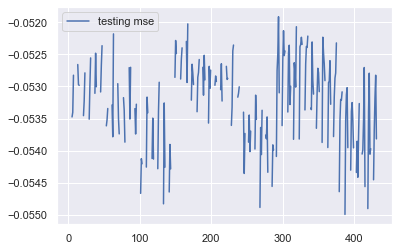

In [79]:
pdf = pd.DataFrame(all_training_scores['mean_test_score'], columns=['testing mse'])
pdf.plot()

# Training R2

In [80]:
y_train_hat = search.predict(x_train)

r2_train = metrics.r2_score(y_train, y_train_hat)
print('R2 (training) = {}'.format(r2_train))

print('Score (training) = {}'.format(search.score(x_train,y_train)))

R2 (training) = 0.650824044459341
Score (training) = -0.04134792880460835


In [81]:
# validation mean_absolute_percentage_error
train_error =  np.abs(y_train - y_train_hat)
mean_error = np.mean(train_error)
min_error = np.min(train_error)
max_error = np.max(train_error)
std_error = np.std(train_error)


print("Model Result (mean - std of error - min - max): %.2f (%.2f) %.2f %.2f MSE" \
      % (mean_error, std_error, min_error, max_error))

Model Result (mean - std of error - min - max): 0.36 (0.25) 0.00 1.00 MSE


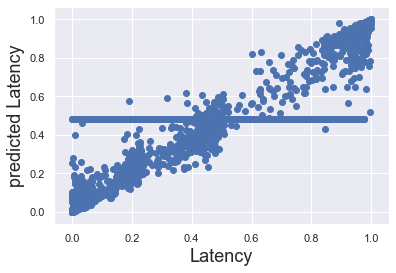

In [82]:
plt.scatter(y_train, y_train_hat)
plt.xlabel('Latency', size=18)
plt.ylabel("predicted Latency", size=18)
plt.show()

Text(0.5, 1.0, 'Residual PDF')

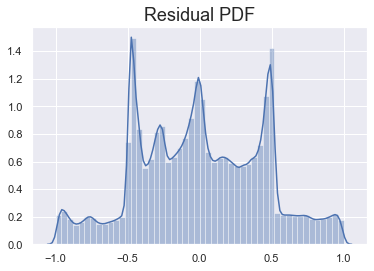

In [83]:
sns.distplot(y_train - y_train_hat)
plt.title('Residual PDF', size=18)

# Testing

In [84]:
y_test_hat = search.predict(x_test)

<function matplotlib.pyplot.show(*args, **kw)>

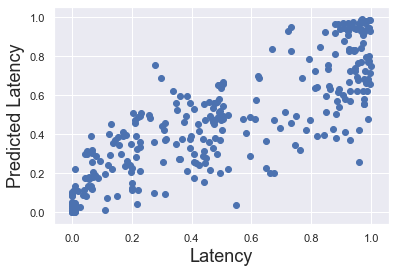

In [85]:
plt.scatter(y_test, y_test_hat)
plt.xlabel('Latency', size=18)
plt.ylabel('Predicted Latency', size=18)
plt.show

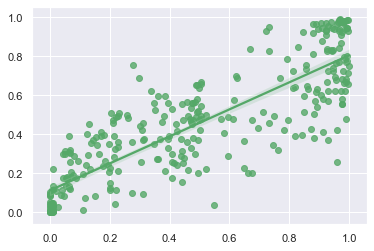

In [86]:
ax = sns.regplot(x=y_test, y=y_test_hat, color='g')

In [87]:
perf = pd.DataFrame(y_test_hat, columns=['prediction'])
perf['target'] = y_test
perf.head()

prediction  target
0      0.0047  0.0016
1      0.0038  0.0071
2      0.0043  0.0093
3      0.0038  0.0027
4      0.0033  0.0016

In [88]:
# testing mean_absolute_percentage_error
perf['residual'] = perf['prediction'] - perf['target']
perf['difference%'] = np.absolute(perf['residual'] * 100 / perf['target'])
perf

prediction  target  residual  difference%
0        0.0047  0.0016    0.0031     195.0562
1        0.0038  0.0071   -0.0033      46.6165
2        0.0043  0.0093   -0.0049      53.3461
3        0.0038  0.0027    0.0011      41.0596
4        0.0033  0.0016    0.0018     111.4607
..          ...     ...       ...          ...
313      0.9450  0.9945   -0.0495       4.9755
314      0.9293  0.9967   -0.0674       6.7628
315      0.9849  0.9945   -0.0096       0.9619
316      0.8336  0.9384   -0.1048      11.1666
317      0.9682  0.9780   -0.0098       1.0006

[318 rows x 4 columns]

In [89]:
perf.describe()

prediction   target  residual  difference%
count    318.0000 318.0000  318.0000     318.0000
mean       0.4462   0.4823   -0.0361     260.3551
std        0.2959   0.3622    0.1924   1,280.0756
min        0.0031   0.0005   -0.7000       0.0339
25%        0.2080   0.1302   -0.1604      13.2577
50%        0.4267   0.4585    0.0014      34.5029
75%        0.6578   0.8859    0.0860      83.7215
max        0.9886   1.0000    0.4766  18,163.7037

In [90]:
pd.options.display.max_rows = 999
pd.set_option('display.float_format', lambda x: '%.2f' % x)
perf.sort_values(by = ['difference%'])

prediction  target  residual  difference%
307        0.97    0.97     -0.00         0.03
312        0.98    0.98      0.00         0.13
305        0.97    0.97      0.00         0.25
220        0.49    0.49     -0.00         0.27
309        0.95    0.94      0.00         0.43
300        0.98    0.99     -0.00         0.49
301        0.96    0.96      0.01         0.57
139        0.35    0.35      0.00         0.66
263        0.93    0.92      0.01         0.68
125        0.47    0.48     -0.00         0.71
288        0.79    0.79     -0.01         0.76
265        0.97    0.98     -0.01         0.83
315        0.98    0.99     -0.01         0.96
308        0.99    1.00     -0.01         0.97
317        0.97    0.98     -0.01         1.00
272        0.94    0.95     -0.01         1.03
306        0.93    0.92      0.01         1.20
283        0.97    0.96      0.01         1.22
279        0.91    0.92     -0.01         1.43
109        0.46    0.47     -0.01         1.49
296        0.98    0.97      0.02         1.57
92         0.42    0.42     -0.01         1.58
210        0.39    0.40     -0.01         1.75
310        0.84    0.83      0.02         1.98
165        0.50    0.51     -0.01         2.02
295        0.98    0.96      0.02         2.06
282        0.99    0.97      0.02         2.11
179        0.37    0.37      0.01         2.19
299        0.94    0.97     -0.03         2.62
168        0.48    0.47      0.01         2.64
271        0.95    0.93      0.02         2.65
303        0.88    0.91     -0.03         3.56
311        0.97    0.94      0.03         3.70
304        0.93    0.97     -0.04         3.76
100        0.50    0.52     -0.02         3.84
106        0.38    0.39     -0.02         3.89
294        0.95    0.91      0.04         3.98
126        0.51    0.49      0.02         4.32
292        0.94    0.99     -0.05         4.63
198        0.45    0.48     -0.02         4.67
264        0.92    0.88      0.04         4.86
302        0.94    0.90      0.04         4.87
187        0.52    0.50      0.02         4.88
273        0.94    0.99     -0.05         4.91
313        0.95    0.99     -0.05         4.98
277        0.97    0.92      0.05         5.00
275        0.93    0.97     -0.05         5.05
205        0.48    0.51     -0.03         5.10
110        0.47    0.50     -0.03         5.22
215        0.21    0.20      0.01         5.38
77         0.47    0.44      0.03         5.98
43         0.03    0.03      0.00         6.29
289        0.91    0.97     -0.06         6.48
119        0.57    0.61     -0.04         6.57
314        0.93    1.00     -0.07         6.76
298        0.97    0.91      0.06         7.11
108        0.45    0.42      0.03         7.21
112        0.50    0.46      0.03         7.21
98         0.21    0.23     -0.02         7.46
278        0.81    0.88     -0.07         7.74
281        0.96    0.89      0.07         8.18
124        0.55    0.50      0.04         8.55
269        0.92    0.85      0.08         8.98
24         0.01    0.01      0.00         9.20
103        0.84    0.93     -0.09         9.43
267        0.96    0.88      0.09         9.83
169        0.69    0.62      0.06        10.33
104        0.69    0.77     -0.08        10.78
276        0.87    0.97     -0.11        10.91
285        0.82    0.93     -0.10        11.06
293        0.72    0.81     -0.09        11.09
316        0.83    0.94     -0.10        11.17
88         0.75    0.85     -0.10        11.96
258        0.70    0.62      0.08        12.25
290        0.83    0.95     -0.12        12.27
284        0.83    0.94     -0.12        12.58
262        0.82    0.73      0.09        12.71
291        0.84    0.97     -0.12        12.74
32         0.23    0.20      0.03        12.94
79         0.53    0.47      0.06        13.12
148        0.38    0.44     -0.06        13.68
6          0.01    0.01      0.00        13.98
135        0.73    0.85     -0.12        14.06
219        0.26    0.30     -0.05        15.12
163       

# *** Prediction Accuracy

In [91]:
r2_test = metrics.r2_score(y_test, y_test_hat)
print('R2 (testing) = {}'.format(r2_test))

# also: R-Squared could obtain with
# pline.score(x_test, y_test)

R2 (testing) = 0.7079123205304015


In [92]:
print(np.sqrt(mean_squared_error(y_test,y_test_hat)))

0.19545868779167264
